##### SKIN DISEASE DETECTION USING EFFICIENT


In [40]:
from torchvision.models import efficientnet_b0
import torch
import torch.nn as nn
from torchvision.transforms import v2
from torchvision import datasets, models
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import os
import copy

import os
import warnings
warnings.filterwarnings('ignore')

In [41]:
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
from torch.amp import GradScaler, autocast

In [42]:
torch.cuda.empty_cache()

In [43]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA used by PyTorch:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.8.0+cu126
CUDA used by PyTorch: 12.6
CUDA available: True


In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### Transformations

In [45]:
BATCH_SIZE = 16  # Instead of 32
IMG_SZ = 224     # Instead of 244

DATA_DIR = 'SkinDisease/'
TRAIN_DIR = 'SkinDisease/train'
TEST_DIR = 'SkinDisease/test'
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])


train_transforms = v2.Compose([
    v2.PILToTensor(),
    v2.Resize((IMG_SZ, IMG_SZ)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomResizedCrop((IMG_SZ, IMG_SZ), antialias=True),
    v2.RandomRotation(10),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

test_transforms = v2.Compose([
    v2.PILToTensor(),
    v2.Resize((IMG_SZ, IMG_SZ)),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=mean, std=std)
])

In [46]:
class_names = []
img_count = []

for dir in os.listdir(TRAIN_DIR):
    class_names.append(dir)
    img_count.append(len([file for file in os.listdir(TRAIN_DIR +'/'+ dir)]))

print("No.of class labels we have is:", len(class_names))
print("our classes are:", class_names)

No.of class labels we have is: 22
our classes are: ['Benign_tumors', 'Vitiligo', 'Infestations_Bites', 'Warts', 'Unknown_Normal', 'Eczema', 'Moles', 'Vascular_Tumors', 'Acne', 'Lichen', 'Sun_Sunlight_Damage', 'SkinCancer', 'Candidiasis', 'Actinic_Keratosis', 'Tinea', 'Psoriasis', 'DrugEruption', 'Lupus', 'Seborrh_Keratoses', 'Rosacea', 'Bullous', 'Vasculitis']


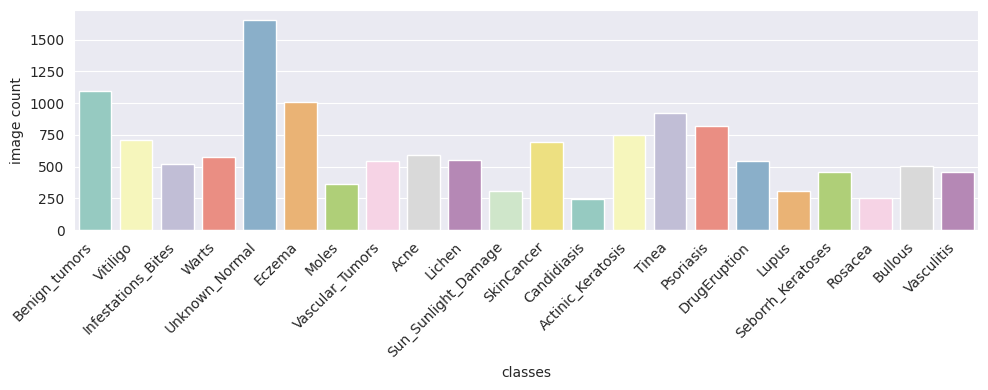

In [47]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 4))
sns.barplot(x=class_names, y=img_count, palette='Set3')
plt.xlabel('classes')
plt.ylabel('image count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [48]:
print(img_count)

[1093, 714, 524, 580, 1651, 1010, 361, 543, 593, 553, 312, 693, 248, 748, 923, 820, 547, 311, 455, 254, 504, 461]


##### data loaders

In [49]:
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_ds = datasets.ImageFolder(TEST_DIR, transform= test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [50]:
from torch.utils.data import random_split, DataLoader
split_ratio = 0.1

train_sz = int((1-split_ratio)*len(train_ds))
val_sz = len(train_ds) - train_sz

train_split, val_split = random_split(train_ds, [train_sz, val_sz])

train_loader = DataLoader(train_split, batch_size=16, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 

##### Implementing focal loss as our criterion

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, device='cpu'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if self.alpha is not None:
            self.alpha = self.alpha.to(device)

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss

##### model, loss, optimizer, scheduler

In [52]:
num_classes = len(img_count)
print(num_classes)

counts = torch.tensor(img_count, dtype=torch.float)
alpha = 1.0 / counts
alpha = alpha / alpha.sum()

22


In [53]:
# Replace your existing model setup cell with this:

model = efficientnet_b0(weights='DEFAULT')
model.to(device)

criterion = FocalLoss(alpha = alpha, gamma = 2, device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=4, factor=0.3)

# Add mixed precision scaler - THIS IS THE KEY OPTIMIZATION
scaler = GradScaler()
print("✅ Mixed precision scaler initialized!")
print(f"Model device: {next(model.parameters()).device}")
print(f"Memory before training: {torch.cuda.memory_allocated()/1e6:.0f}MB")

✅ Mixed precision scaler initialized!
Model device: cuda:0
Memory before training: 98MB


##### class weights for imbalanced classes

In [54]:
import numpy as np

labels =  train_ds.targets
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=np.array(labels))
class_weights = torch.tensor(class_weights,  dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([1.0653, 0.8446, 0.5780, 1.2534, 2.5473, 1.1549, 0.6255, 1.2056, 1.1424,
        2.0313, 1.7499, 0.7704, 2.4871, 1.3884, 0.9116, 2.0248, 0.6844, 0.3826,
        1.1634, 1.3703, 0.8848, 1.0892], device='cuda:0')


##### Training Loop

In [55]:
# Replace your existing training loop with this optimized version:

EPOCHS = 20
best_val_acc = 0
patience, counter = 5, 0
save_path = "eff-best.pth"

import time

for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    model.train()
    train_loss, train_corr, train_total = 0.0, 0, 0
    tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for batch_idx, (images, labels) in enumerate(tqdm_bar):
        # Use non_blocking=True for faster GPU transfer
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        # More efficient gradient zeroing
        optimizer.zero_grad(set_to_none=True)

        # MIXED PRECISION FORWARD PASS - THIS IS THE KEY OPTIMIZATION
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # MIXED PRECISION BACKWARD PASS
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * images.size(0)
        _, pred = outputs.max(1)
        train_corr += pred.eq(labels).sum().item()
        train_total += labels.size(0)

        tqdm_bar.set_postfix(loss=loss.item(), acc=train_corr/train_total)
        
        # Print progress every 100 batches
        # if batch_idx % 100 == 0:
        #     print(f"Epoch {epoch+1}/{EPOCHS}, Batch {batch_idx}/{len(train_loader)}, "
        #           f"Loss: {loss.item():.4f}, GPU: {torch.cuda.memory_allocated()/1e6:.0f}MB")

    train_loss /= train_total   
    train_acc = train_corr/train_total

    # Validation phase (also with mixed precision)
    model.eval()
    val_loss, val_corr, val_total = 0.0, 0, 0

    with torch.no_grad():
        tqdm_2 = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
        for images, labels in tqdm_2:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # Use autocast for validation too (faster inference)
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            val_corr += preds.eq(labels).sum().item()
            val_total += labels.size(0)

            tqdm_2.set_postfix(loss=loss.item(), acc=val_corr/val_total)

    val_loss /= val_total 
    val_acc = val_corr/val_total

    scheduler.step(val_acc)
    
    # Calculate and display epoch timing
    epoch_time = time.time() - epoch_start

    print(f"Epoch {epoch+1}/{EPOCHS} completed in {epoch_time:.1f}s  Train: {train_loss:.4f}, {train_acc:.4f} — Val: {val_loss:.4f}, {val_acc:.4f}") 
    print(f"GPU Memory: {torch.cuda.memory_allocated()/1e6:.0f}MB / {torch.cuda.memory_reserved()/1e6:.0f}MB")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print("Best model saved.")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping.")
            break
    
    # torch.cuda.empty_cache()

model.load_state_dict(torch.load(save_path))
print("TRAINING COMPLETED WITH MIXED PRECISION OPTIMIZATION! 🚀")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Final GPU memory usage: {torch.cuda.memory_allocated()/1e6:.0f}MB")


Epoch 1/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 15.57it/s, acc=0.384, loss=0.0726]


Epoch 1/20 completed in 74.8s  Train: 0.0871, 0.2974 — Val: 0.0659, 0.3842
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 2/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 17.23it/s, acc=0.418, loss=0.0774]


Epoch 2/20 completed in 124.9s  Train: 0.0659, 0.3850 — Val: 0.1932, 0.4180
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 3/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 17.24it/s, acc=0.469, loss=0.0517]


Epoch 3/20 completed in 130.8s  Train: 0.0594, 0.4264 — Val: 0.0522, 0.4691
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 4/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 16.77it/s, acc=0.49, loss=0.0422] 


Epoch 4/20 completed in 132.6s  Train: 0.0558, 0.4542 — Val: 0.0513, 0.4899
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 5/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 16.47it/s, acc=0.484, loss=0.0326]


Epoch 5/20 completed in 132.9s  Train: 0.0529, 0.4762 — Val: 0.0524, 0.4842
GPU Memory: 162MB / 958MB


Epoch 6/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 16.08it/s, acc=0.51, loss=0.0193] 


Epoch 6/20 completed in 133.5s  Train: 0.0497, 0.4900 — Val: 0.0462, 0.5101
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 7/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 15.60it/s, acc=0.519, loss=0.0724]


Epoch 7/20 completed in 133.7s  Train: 0.0478, 0.5025 — Val: 0.0481, 0.5194
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 8/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 16.15it/s, acc=0.527, loss=0.0363]


Epoch 8/20 completed in 133.5s  Train: 0.0454, 0.5239 — Val: 0.0448, 0.5273
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 9/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 16.62it/s, acc=0.511, loss=0.0551]


Epoch 9/20 completed in 133.4s  Train: 0.0433, 0.5371 — Val: 0.0633, 0.5108
GPU Memory: 162MB / 958MB


Epoch 10/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 16.74it/s, acc=0.556, loss=0.0226]


Epoch 10/20 completed in 133.4s  Train: 0.0420, 0.5500 — Val: 0.0412, 0.5561
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 11/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 16.23it/s, acc=0.557, loss=0.0517]


Epoch 11/20 completed in 133.5s  Train: 0.0397, 0.5692 — Val: 0.0438, 0.5568
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 12/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 16.47it/s, acc=0.558, loss=0.0593]


Epoch 12/20 completed in 133.6s  Train: 0.0385, 0.5818 — Val: 0.0438, 0.5583
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 13/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 16.21it/s, acc=0.575, loss=0.0301]


Epoch 13/20 completed in 133.5s  Train: 0.0373, 0.5832 — Val: 0.0416, 0.5748
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 14/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 16.21it/s, acc=0.557, loss=0.066]  


Epoch 14/20 completed in 133.5s  Train: 0.0357, 0.5980 — Val: 0.0430, 0.5568
GPU Memory: 162MB / 958MB


Epoch 15/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 16.10it/s, acc=0.573, loss=0.0143]


Epoch 15/20 completed in 133.7s  Train: 0.0343, 0.6049 — Val: 0.0401, 0.5734
GPU Memory: 162MB / 958MB


Epoch 16/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 15.56it/s, acc=0.578, loss=0.0373] 


Epoch 16/20 completed in 134.1s  Train: 0.0334, 0.6205 — Val: 0.0403, 0.5784
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 17/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 15.30it/s, acc=0.571, loss=0.0338]


Epoch 17/20 completed in 134.0s  Train: 0.0321, 0.6278 — Val: 0.0403, 0.5712
GPU Memory: 162MB / 958MB


Epoch 18/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 15.19it/s, acc=0.622, loss=0.0137]


Epoch 18/20 completed in 134.2s  Train: 0.0317, 0.6329 — Val: 0.0358, 0.6216
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 19/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 15.68it/s, acc=0.63, loss=0.0142]  


Epoch 19/20 completed in 133.9s  Train: 0.0300, 0.6445 — Val: 0.0353, 0.6302
GPU Memory: 162MB / 958MB
Best model saved.


Epoch 20/20 [Val]: 100%|██████████| 87/87 [00:05<00:00, 15.31it/s, acc=0.589, loss=0.0291]


Epoch 20/20 completed in 134.1s  Train: 0.0294, 0.6491 — Val: 0.0412, 0.5892
GPU Memory: 162MB / 958MB
TRAINING COMPLETED WITH MIXED PRECISION OPTIMIZATION! 🚀
Best validation accuracy: 0.6302
Final GPU memory usage: 162MB


In [56]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.tolist())

print(classification_report(all_labels, all_preds, target_names=train_ds.classes))

                     precision    recall  f1-score   support

               Acne       0.50      0.05      0.08        65
  Actinic_Keratosis       0.50      0.02      0.05        83
      Benign_tumors       0.24      0.45      0.32       121
            Bullous       0.62      0.18      0.28        55
        Candidiasis       0.00      0.00      0.00        27
       DrugEruption       0.40      0.10      0.16        61
             Eczema       0.12      0.02      0.03       112
 Infestations_Bites       0.12      0.17      0.14        60
             Lichen       0.20      0.07      0.10        61
              Lupus       0.00      0.00      0.00        34
              Moles       0.08      0.72      0.15        40
          Psoriasis       0.00      0.00      0.00        88
            Rosacea       0.00      0.00      0.00        28
  Seborrh_Keratoses       0.50      0.27      0.35        51
         SkinCancer       0.00      0.00      0.00        77
Sun_Sunlight_Damage    